In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [42]:
#Read the data
# data=pd.read_csv('A04 FILA 20A_output_stem_trackable_objects.csv')
# data.head()
data1=pd.read_excel('Copy A04 FILA 20A_output_stem_trackable_objects.xlsx')
data2=pd.read_excel('Copy A04 FILA 01B_output_stem_trackable_objects.xlsx')
data3=pd.read_excel("Copy p22_h44_lado_B_output_stem_trackable_objects.xlsx")
data4=pd.read_excel('Copy A04 FILA 10A_output_stem_trackable_objects.xlsx')

# data1=data1[data1['counted']==True]
# data2=data2[data2['counted']==True]
# data3=data3[data3['counted']==True]
# data4=data4[data4['counted']==True]

files=[data1,data2,data3,data4]

# for f in files:
#     f['ground_truth']=f['ground_truth'].map({'True Positive':1,'False Positive':0}).astype(bool)


# rs1=RobustScaler().fit_transform(data1)
# rs2=RobustScaler().fit_transform(data2)
# rs3=RobustScaler().fit_transform(data3)
# rs4=RobustScaler().fit_transform(data4)

In [43]:
# d1=pd.DataFrame(rs1,columns=data1.columns, index=data1.index)
# d2=pd.DataFrame(rs2,columns=data2.columns, index=data2.index)
# d3=pd.DataFrame(rs3,columns=data3.columns, index=data3.index)
# d4=pd.DataFrame(rs4,columns=data4.columns, index=data4.index)

In [44]:
# data1

In [45]:
#Get the velocity for each object and observation
def assign_velocities(df):
    
    def compute_vel(group):
        # Compute velocity as the difference in centroids_x over difference in frames
        vel = group['centroids_x'].diff() / group['frames'].diff()
        # Replace the first observation (NaN) with the group's mean velocity
        if not vel.empty:
            vel.iloc[0] = vel.mean()  # .mean() ignores NaN by default
        return vel

    # Use groupby to apply compute_vel for each object_id
    df['velocity'] = df.groupby('object_id', group_keys=False)[['centroids_x','frames']].apply(compute_vel)
    return df

In [46]:
#Get the number of frames for each object

for f in files:

    assign_velocities(f)
    
    if f['velocity'].mean()<0:
        f['velocity']=-f['velocity']

    frame_counts = f.groupby('object_id')['frames'].apply(lambda x: x.max() - x.min())
    frame_info=f.groupby('object_id')['frames'].min()

    f['frames']=[frame_counts.get(f.loc[i,'object_id']) for i in range(len(f))]
    f['first_frame']=[frame_info.get(f.loc[i,'object_id']) for i in range(len(f))]

    

    f['mean_velocity_fps']=[f.groupby('object_id')['velocity'].mean().get(f.loc[i,'object_id']) for i in range(len(f))]
    f['std_area']=[f.groupby('object_id')['area'].std().get(f.loc[i,'object_id']) for i in range(len(f))]
    f['adj_std_area']=f['std_area']/f['frames']




In [47]:
ps1=data1[data1['counted']==True].reset_index(drop=True)
ps2=data2[data2['counted']==True].reset_index(drop=True)
ps3=data3[data3['counted']==True].reset_index(drop=True)
ps4=data4[data4['counted']==True].reset_index(drop=True)

ps=[ps1,ps2,ps3,ps4]

for f in ps:
    f['ground_truth']=f['ground_truth'].map({'True Positive':1,'False Positive':0}).astype(bool)
    f.drop('counted',axis=1,inplace=True)


    ffp=pd.DataFrame(f.groupby('object_id')['first_frame'].mean())
    # print(ffp)
    # print(ffp.mean())
    ffp['dist']=[ffp.iloc[i,0] if i==0 else ffp.iloc[i,0]-ffp.iloc[i-1,0] for i in range(len(ffp))]
    f['dist_between_apps']=[ffp['dist'].get(f.loc[i,'object_id']) for i in range(len(f))]

    f.drop('first_frame',axis=1,inplace=True)

    normalized_speed=MinMaxScaler().fit_transform(pd.DataFrame(f['mean_velocity_fps']))

    f['adjusted_frames']=[f['frames'][i]*normalized_speed[i][0] for i in range(len(normalized_speed))]

    #f['preds']=1


# Reorganize columns so that 'ground_truth' and 'preds' are the second to last and last columns
columns = ['object_id','ground_truth'] + [col for col in ps1.columns if col not in ['object_id','ground_truth']]
ps1 = ps1[columns]
ps2 = ps2[columns]
ps3 = ps3[columns]
ps4 = ps4[columns]

In [48]:
# ps1

In [49]:
rs1=RobustScaler().fit_transform(ps1.drop(['object_id','ground_truth'],axis=1))
rs2=RobustScaler().fit_transform(ps2.drop(['object_id','ground_truth'],axis=1))
rs3=RobustScaler().fit_transform(ps3.drop(['object_id','ground_truth'],axis=1))
rs4=RobustScaler().fit_transform(ps4.drop(['object_id','ground_truth'],axis=1))


In [50]:
scaled_cols=ps1.drop(['object_id','ground_truth'],axis=1).columns

sps1=ps1.copy()
sps1.set_index('object_id', inplace=True)
sps1[scaled_cols]=rs1

sps2=ps2.copy()
sps2.set_index('object_id', inplace=True)
sps2[scaled_cols]=rs2

sps3=ps3.copy()
sps3.set_index('object_id', inplace=True)
sps3[scaled_cols]=rs3

sps4=ps4.copy()
sps4.set_index('object_id', inplace=True)
sps4[scaled_cols]=rs4

In [51]:
# sps4.groupby('object_id').mean()

In [52]:
data=pd.concat([sps1,sps2,sps3,sps4],axis=0)
data.reset_index(inplace=True)
data.drop('object_id',axis=1,inplace=True)

In [53]:
data

,ground_truth,centroids_x,centroids_y,aspect_ratio,area,frames,scores,velocity,mean_velocity_fps,std_area,adj_std_area,dist_between_apps,adjusted_frames
0,True,-0.806352,-3.927928,-0.273414,-1.230798,0.133333,-0.666667,0.024350,-0.104243,0.052905,0.058228,0.500000,-0.004858
1,True,-0.771063,-3.846847,0.945469,-1.037296,0.133333,-0.333333,0.115108,-0.104243,0.052905,0.058228,0.500000,-0.004858
2,True,-0.755183,-3.675676,0.976859,-0.972762,0.133333,-0.333333,-0.517986,-0.104243,0.052905,0.058228,0.500000,-0.004858
3,True,-0.746361,-3.495495,-0.273414,-0.924830,0.133333,0.066667,-0.748201,-0.104243,0.052905,0.058228,0.500000,-0.004858
4,True,-0.732245,-3.189189,-0.125749,-0.788347,0.133333,-0.266667,-0.575540,-0.104243,0.052905,0.058228,0.500000,-0.004858
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10835,True,0.709793,-0.380795,1.546183,-0.507925,3.080000,0.222222,-0.950000,-1.174789,1.063675,-0.365403,-1.645161,-1.083822
10836,True,0.707996,-0.460265,1.488110,-0.521346,3.080000,-1.703704,-1.050000,-1.174789,1.063675,-0.365403,-1.645161,-1.083822
10837,True,0.709793,-0.493377,1.459532,-0.553813,3.080000,-2.000000,-0.950000,-1.174789,1.063675,-0.365403,-1.645161,-1.083822
10838,True,0.734951,-0.559603,1.741097,-0.751311,3.080000,-2.111111,-0.766667,-1.174789,1.063675,-0.365403,-1.645161,-1.083822


In [54]:
#Split the data into training and test sets
x,y=data.drop(['ground_truth'],axis=1),data['ground_truth']

#Upsample the minority class (ground_truth=0) to balance the dataset
# from sklearn.utils import resample
# x_0 = x[y == 0]
# x_1 = x[y == 1]
# y_0 = y[y == 0]
# y_1 = y[y == 1]
# x_0_upsampled, y_0_upsampled = resample(x_0, y_0, replace=True, n_samples=len(x_1), random_state=42)
# x = pd.concat([x_0_upsampled, x_1])
# y = pd.concat([y_0_upsampled, y_1])

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
#Define the classification forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True)

#Train the model
model.fit(x_train, y_train)

#Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

#Calculate the metrics of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


In [56]:
#Print the classification report
print('Classification report:\n',classification_report(y_test, y_pred))
#Print the confusion matrix
print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

#Print the accuracy, recall, precision, f1 score and roc_auc
print(f'\nAccuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

Classification report:
               precision    recall  f1-score   support

       False       1.00      0.97      0.99        78
        True       1.00      1.00      1.00      2090

    accuracy                           1.00      2168
   macro avg       1.00      0.99      0.99      2168
weighted avg       1.00      1.00      1.00      2168

Confusion Matrix:
 [[  76    2]
 [   0 2090]]

Accuracy: 0.9991
Recall: 1.0000
Precision: 0.9990
F1 Score: 0.9995
ROC AUC: 1.0000


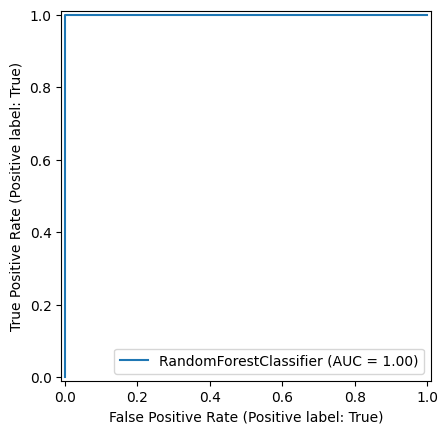

In [57]:
RocCurveDisplay.from_estimator(model, x_test, y_test)

In [58]:
# en=pd.concat([x_test,y_test],axis=1)
# en['preds']=y_pred

# with pd.option_context('display.max_rows', None):
#     display(en.groupby('object_id').mean())

In [59]:
#Save the Random Forest model to be able to use it later
import joblib
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [60]:
#Load the model
loaded_model = joblib.load('random_forest_model.pkl')
#Make predictions on the test set using the loaded model
y_pred_loaded = loaded_model.predict(x_test)
y_pred_proba_loaded = loaded_model.predict_proba(x_test)[:, 1]
#Calculate the metrics of the loaded model
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
recall_loaded = recall_score(y_test, y_pred_loaded)
precision_loaded = precision_score(y_test, y_pred_loaded)
f1_loaded = f1_score(y_test, y_pred_loaded)
roc_auc_loaded = roc_auc_score(y_test, y_pred_proba_loaded)
#Print the classification report of the loaded model
print('Classification report of the loaded model:\n',classification_report(y_test, y_pred_loaded))
#Print the confusion matrix of the loaded model
print('Confusion Matrix of the loaded model:\n',confusion_matrix(y_test, y_pred_loaded))
#Print the accuracy, recall, precision, f1 score and roc_auc of the loaded model
print(f'\nAccuracy of the loaded model: {accuracy_loaded:.4f}')
print(f'Recall of the loaded model: {recall_loaded:.4f}')
print(f'Precision of the loaded model: {precision_loaded:.4f}')
print(f'F1 Score of the loaded model: {f1_loaded:.4f}')
print(f'ROC AUC of the loaded model: {roc_auc_loaded:.4f}')

Classification report of the loaded model:
               precision    recall  f1-score   support

       False       1.00      0.97      0.99        78
        True       1.00      1.00      1.00      2090

    accuracy                           1.00      2168
   macro avg       1.00      0.99      0.99      2168
weighted avg       1.00      1.00      1.00      2168

Confusion Matrix of the loaded model:
 [[  76    2]
 [   0 2090]]

Accuracy of the loaded model: 0.9991
Recall of the loaded model: 1.0000
Precision of the loaded model: 0.9990
F1 Score of the loaded model: 0.9995
ROC AUC of the loaded model: 1.0000
